In [1]:
###### Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time
import joblib

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn import metrics

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

#Stats
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

### Exploratory Data Analysis
#### Data

In [2]:
test = pd.read_csv('./test.csv')
train = pd.read_csv('./train.csv')
print(test.head())
print('**' * 50)
print(train.head())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez  
****************************************************************************************************
  PassengerId Ho

In [3]:
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

Train set shape: (8693, 14)
Test set shape: (4277, 13)


Missing values

In [4]:
print('Training missing data:')
print(train.isna().sum())
print(' ')
print('Testing missing data:')
print(test.isna().sum())

Training missing data:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
 
Testing missing data:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Duplicates

In [5]:
print(f'Duplicates in train set: {train.duplicated().sum()}, ({np.round(100*train.duplicated().sum()/len(train),1)}%)')
print(' ')
print(f'Duplicates in test set: {test.duplicated().sum()}, ({np.round(100*test.duplicated().sum()/len(test),1)}%)')

Duplicates in train set: 0, (0.0%)
 
Duplicates in test set: 0, (0.0%)


#### Cardinality of features

there are 6 numerical features, 4 categorical features and 3 qualitative features

In [6]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

#### Data types

In [7]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

We will need to transform these data to numeric so that we can use it for the machine learning model.

#### EDA

Text(0.5, 1.0, 'Target Distribution')

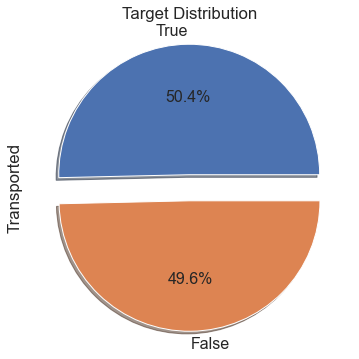

In [8]:
plt.figure(figsize=(6,6))

train['Transported'].value_counts().plot.pie(explode=[0.1, 0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target Distribution")

The target is fairly equally distributed, so we dont have to consider under or oversampling.

Text(0.5, 0, 'Age(years)')

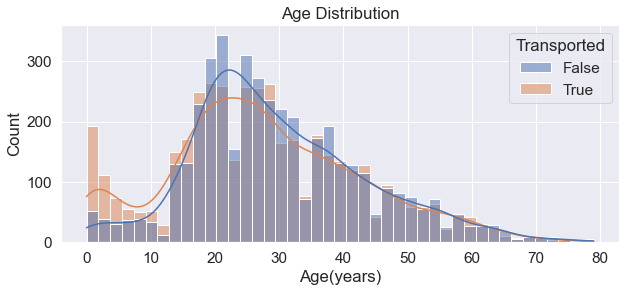

In [9]:
plt.figure(figsize=(10,4))
sns.histplot(data=train, x='Age', hue="Transported", kde=True)

plt.title("Age Distribution")
plt.xlabel("Age(years)")

Note:
- Passengers below 16 years old are more likely to be transported
- Passengers between 18 and 40 are less likely to be transported
- The amount of passgengers transported is more or less equal above 40 years old

Takeaways:
- Create a new binning feature of age group

<function matplotlib.pyplot.show(close=None, block=None)>

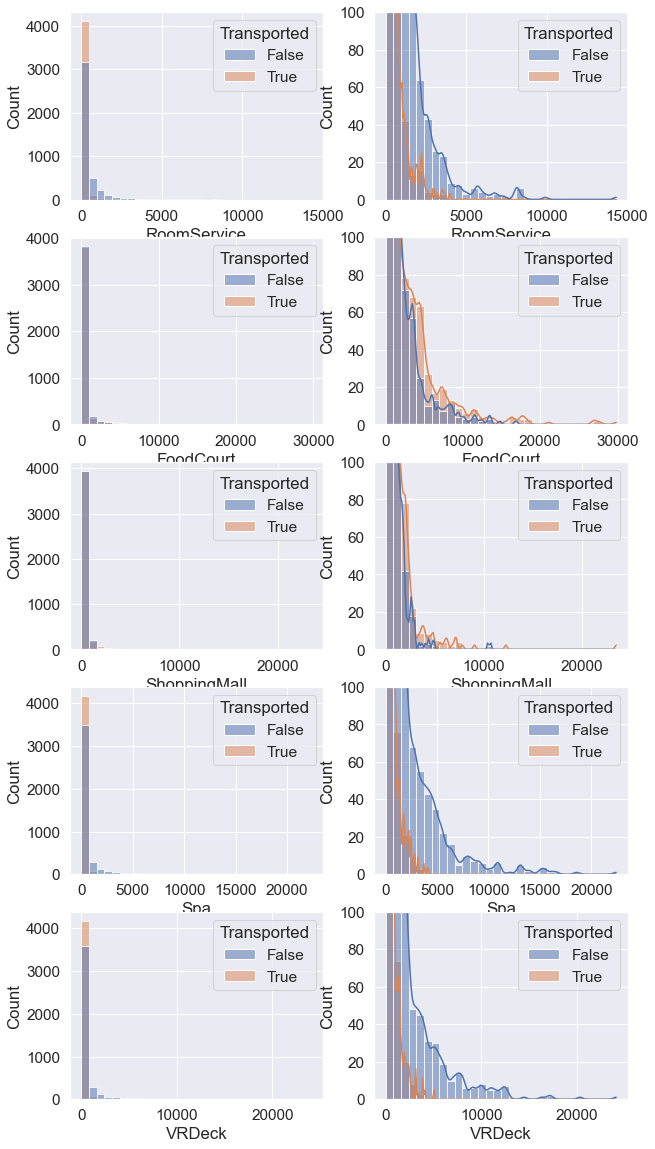

In [10]:
# Defining expenditure features
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

#Plotting expenditure features (Left: whole data, Right: Skewed)
fig = plt.figure(figsize = (10,20))
for i, var_name in enumerate(exp_feats):
    ax = fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, hue='Transported')
    
    
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    
fig.tight_layout
plt.show

Note:
- Passengers are mostly spending little to none during the trip (left)
- Small percentage of passengers are outliers of passengers spend up to 20,000
- The amount spent by passengers drops significantly before 5000 (right)

Takeaways:
- Create new feature tracking the total spendings of all passengers
- Create new feature to see if passengers spend anything during the trip
- Log transform to reduce skew of data

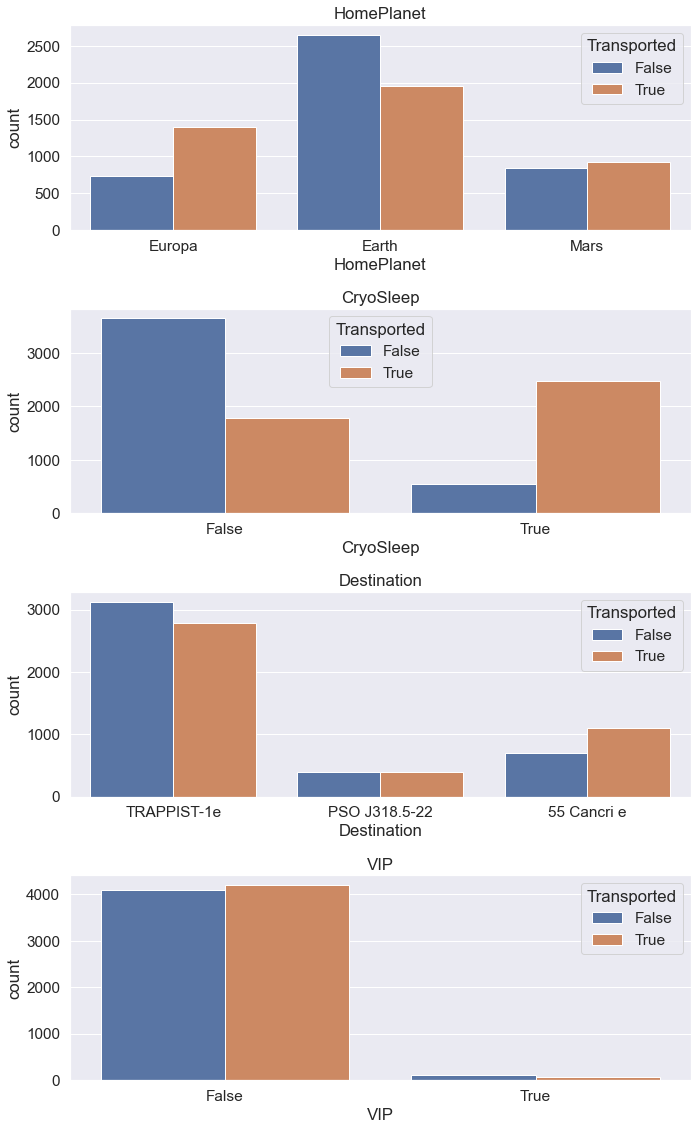

In [11]:
#Defining categorical features
cat_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

#Plotting categorical features comparing between Transported or not
fig = plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

Note:
- Majority of the passengers are not VIP passengers, and VIP seems to not be an important factor to wether a passenger is transported or not
- In contrast the CryoSleep appears to be a useful feature.

Takeaway:
- Consider dropping the VIP column to prevent overfitting

##### Qualitative Features

We would need to transform these datas into more useful features

In [12]:
qual_feats = ['PassengerId', 'Cabin', 'Name']

train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


Note:
- PassengerId has a format of gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
- Cabin has a format of deck/num/side, where side can be P for port and S for Starboard

Takeaway:
- Extract Group and Group size from PassengerId
- Extract Deck, Cabin Number and Side from the Cabin column
- Extract Surname from the Name column to see passengers from the same family

# Feature Engineering

#### Age Group

Binning Age column into groups

Text(0.5, 1.0, 'Age group distribution')

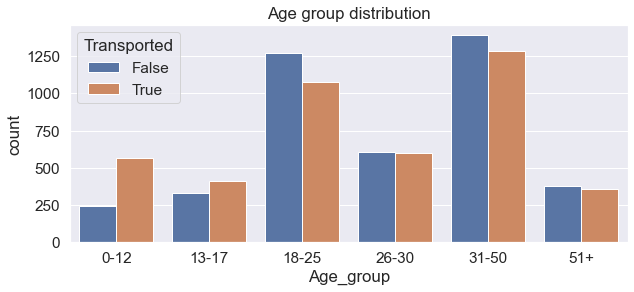

In [13]:
# New binning features for Training
train['Age_group']=np.nan
train.loc[train['Age']<=12, 'Age_group'] = '0-12'
train.loc[(train['Age']>12) & (train['Age']<18), 'Age_group'] = '13-17'
train.loc[(train['Age']>=18) & (train['Age']<=25), 'Age_group'] = '18-25'
train.loc[(train['Age']>25) & (train['Age']<=30), 'Age_group'] = '26-30'
train.loc[(train['Age']>30) & (train['Age']<=50), 'Age_group'] = '31-50'
train.loc[train['Age']>50, 'Age_group'] = '51+'

# New binning features for Testing
test['Age_group']=np.nan
test.loc[test['Age']<=12, 'Age_group'] = '0-12'
test.loc[(test['Age']>12) & (test['Age']<18), 'Age_group'] = '13-17'
test.loc[(test['Age']>=18) & (test['Age']<=25), 'Age_group'] = '18-25'
test.loc[(test['Age']>25) & (test['Age']<=30), 'Age_group'] = '26-30'
test.loc[(test['Age']>30) & (test['Age']<=50), 'Age_group'] = '31-50'
test.loc[test['Age']>50, 'Age_group'] = '51+'

# Plot distribution of new features
plt.figure(figsize=(10,4))
g = sns.countplot(data=train, x='Age_group', hue='Transported', order=['0-12', '13-17', '18-25', '26-30', '31-50', '51+'])
plt.title('Age group distribution')

#### Expenditure

Calculate total expediture and identify those who donnot spend at all

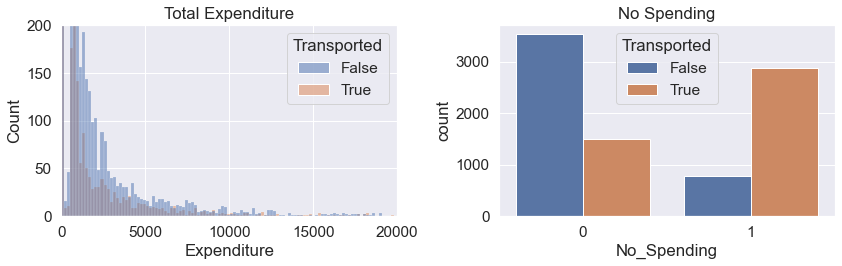

In [14]:
# New features for Training
train['Expenditure'] = train[exp_feats].sum(axis=1)
train['No_Spending'] = (train['Expenditure']==0).astype(int)

# New features for Testing
test['Expenditure'] = test[exp_feats].sum(axis=1)
test['No_Spending'] = (test['Expenditure']==0).astype(int)

# Plot distribution for new features
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total Expenditure')
plt.ylim([0,200])
plt.xlim([0,20000])

# Comparing passengers who spend or not to transported or not
plt.subplot(1,2,2)
sns.countplot(data=train, x='No_Spending', hue='Transported')
plt.title('No Spending')
fig.tight_layout()

#### Groups

Extract Groups and Group Size from the PassengerId

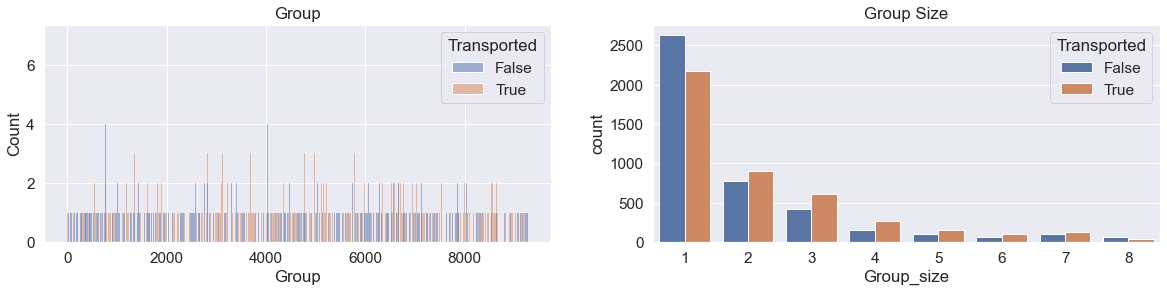

In [15]:
# New feature(Group)
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature(GroupSize)
group_counts = pd.concat([train['Group'], test['Group']]).value_counts()
train['Group_size'] = train['Group'].map(lambda x:group_counts[x])
test['Group_size'] = test['Group'].map(lambda x: group_counts[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group Size')
fig.tight_layout()

Note: 
- Group feature appers to be too big of a cardinality to be of use in our model and would explode the number of dimensions with one-hot encoding
- The Group size however would be useful. 

Takeaway:
- Compress Group size features further by seeing if passengers travel alone or with someone else. The right fig shows that group size = 1 is less likely to be transported than group size > 1

(0.0, 3000.0)

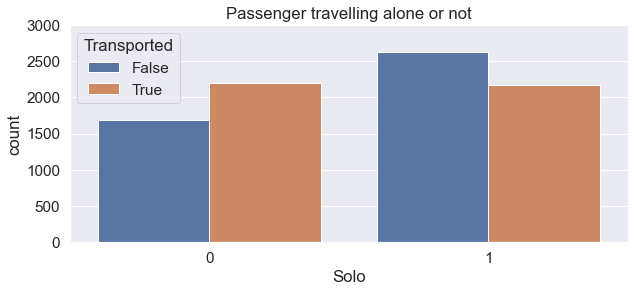

In [16]:
# New featuure
train['Solo'] = (train['Group_size']==1).astype(int)
test['Solo'] = (test['Group_size']==1).astype(int)

# Plot distribution of new feature
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passenger travelling alone or not')
plt.ylim([0,3000])

#### Cabin Location

Extract deck, number and side from cabin feature.

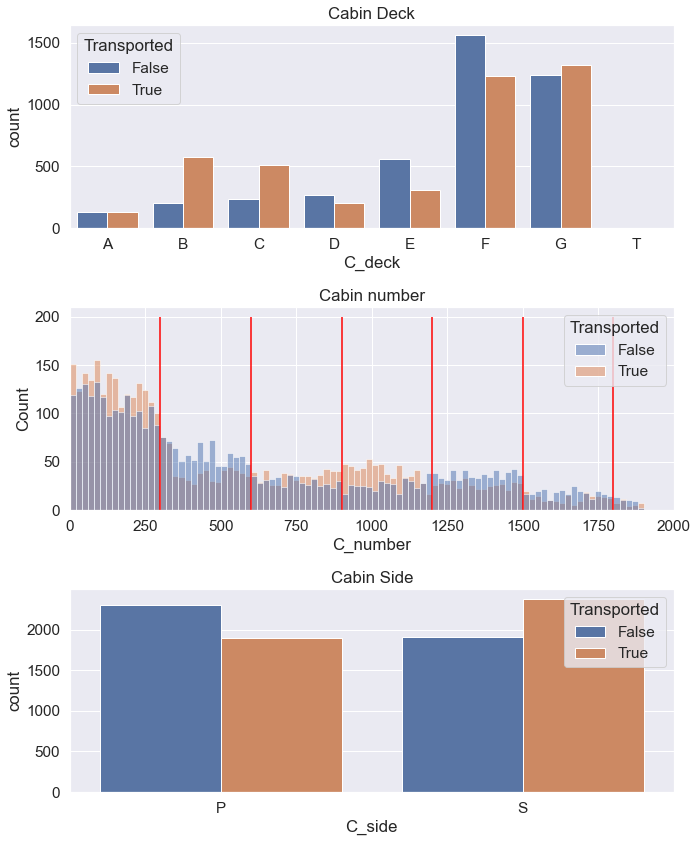

In [17]:
# Replacing missing data with outliers to split the data
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features for Training data
train['C_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['C_number'] = train['Cabin'].apply(lambda x:x.split('/')[1]).astype(int)
train['C_side'] = train['Cabin'].apply(lambda x:x.split('/')[2])

# New features for Testing data
test['C_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['C_number'] = test['Cabin'].apply(lambda x:x.split('/')[1]).astype(int)
test['C_side'] = test['Cabin'].apply(lambda x:x.split('/')[2])

# Assigning NaN values back to the outliers
train.loc[train['C_deck']=='Z', 'C_deck'] = np.nan
train.loc[train['C_number']==9999, 'C_number'] = np.nan
train.loc[train['C_side']=='Z', 'C_side'] = np.nan
test.loc[test['C_deck']=='Z', 'C_deck'] = np.nan
test.loc[test['C_number']==9999, 'C_number'] = np.nan
test.loc[test['C_side']=='Z', 'C_side'] = np.nan

# Dropping Cabin column as we dont need it anymore
train.drop('Cabin', axis = 1, inplace = True)
test.drop('Cabin', axis = 1, inplace = True)

# Plot distribution of new features
fig = plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='C_deck', hue='Transported', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
plt.title('Cabin Deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x=('C_number'), hue='Transported', binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='red')
plt.vlines(600, ymin=0, ymax=200, color='red')
plt.vlines(900, ymin=0, ymax=200, color='red')
plt.vlines(1200, ymin=0, ymax=200, color='red')
plt.vlines(1500, ymin=0, ymax=200, color='red')
plt.vlines(1800, ymin=0, ymax=200, color='red')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='C_side', hue='Transported')
plt.title('Cabin Side')
fig.tight_layout()

Note:
- The Cabin number can be binned by values of 300 cabins.
- Cabin T is an outlier with only 5 entries

Takeaway:
- Compress Cabin number feature further into categorical one for which bin the passengers are in

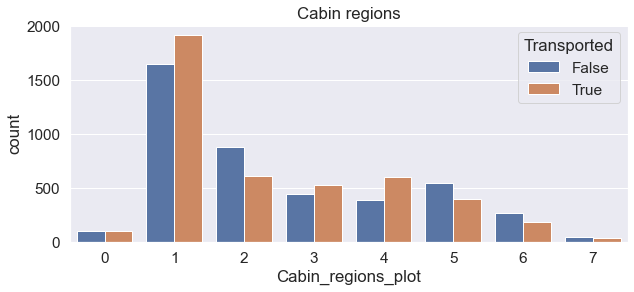

In [18]:
# New feature for Training data
train['C_region1']=(train['C_number']<300).astype(int)
train['C_region2']=((train['C_number']>=300) & (train['C_number']<600)).astype(int)
train['C_region3']=((train['C_number']>=600) & (train['C_number']<900)).astype(int)
train['C_region4']=((train['C_number']>=900) & (train['C_number']<1200)).astype(int)
train['C_region5']=((train['C_number']>=1200) & (train['C_number']<1500)).astype(int)
train['C_region6']=((train['C_number']>=1500) & (train['C_number']<1800)).astype(int)
train['C_region7']=(train['C_number']>=1800).astype(int)

# New feature for Testing data
test['C_region1']=(test['C_number']<300).astype(int)
test['C_region2']=((test['C_number']>=300) & (test['C_number']<600)).astype(int)
test['C_region3']=((test['C_number']>=600) & (test['C_number']<900)).astype(int)
test['C_region4']=((test['C_number']>=900) & (test['C_number']<1200)).astype(int)
test['C_region5']=((test['C_number']>=1200) & (test['C_number']<1500)).astype(int)
test['C_region6']=((test['C_number']>=1500) & (test['C_number']<1800)).astype(int)
test['C_region7']=(test['C_number']>=1800).astype(int)

# Plotting distribution of new features
plt.figure(figsize=(10,4))
train['Cabin_regions_plot']=(train['C_region1']+2*train['C_region2']+3*train['C_region3']+4*train['C_region4']+5*train['C_region5']+6*train['C_region6']+7*train['C_region7']).astype(int)
sns.countplot(data=train, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train.drop('Cabin_regions_plot', axis=1, inplace=True)

#### Last Name

Calculating family size from last name

Text(0.5, 1.0, 'Family Size')

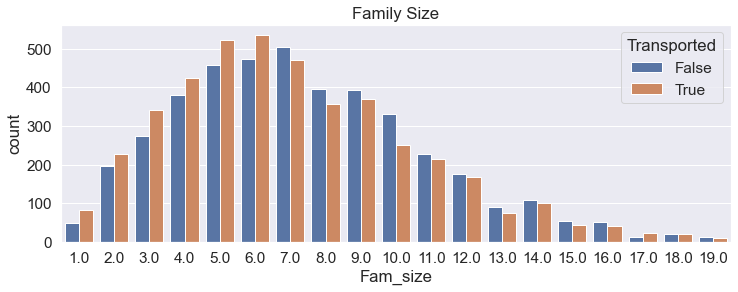

In [19]:
# Replacing missing values with outliers to split the data
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname'] = train['Name'].str.split().str[-1]
test['Surname'] = test['Name'].str.split().str[-1]

# New feature - Family size
fam_count = pd.concat([train['Surname'], test['Surname']]).value_counts()
train['Fam_size'] = train['Surname'].map(lambda x: fam_count[x])
test['Fam_size'] = test['Surname'].map(lambda x: fam_count[x])

# Assigning NaN values back to outliers
train.loc[train['Surname']=='Unknown', 'Surname']=np.nan
train.loc[train['Fam_size']>100, 'Fam_size']=np.nan
test.loc[test['Surname']=='Unknown', 'Surname']=np.nan
test.loc[test['Fam_size']>100, 'Fam_size']=np.nan

# Dropping Name column as we dont need it anymore
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

# Plotting distribution of new features
plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Fam_size', hue='Transported')
plt.title('Family Size')

#### Missing values


##### Combine train and test dataset
This will data cleaning easier. We will be splitting it back later

In [20]:
# Labels and features
y=train['Transported'].copy().astype(bool)
X=train.drop('Transported', axis=1).copy()

# Concatenate the whole dataset
data=pd.concat([X, test], axis=0).reset_index(drop=True)

##### Exploring missing values

In [21]:
# Columns wiht missing values
na_cols = data.columns[data.isna().any()].tolist()

# Summary of missing values
mv = pd.DataFrame(data[na_cols].isna().sum(), columns = ['Amount Missing'])
mv['Percentage Missing'] = np.round(100*mv['Amount Missing']/len(data),2)
mv

,Amount Missing,Percentage Missing
HomePlanet,288,2.22
CryoSleep,310,2.39
Destination,274,2.11
Age,270,2.08
VIP,296,2.28
RoomService,263,2.03
FoodCourt,289,2.23
ShoppingMall,306,2.36
Spa,284,2.19
VRDeck,268,2.07


Missing values only makes up about 2% of the dataset, which is fairly small.

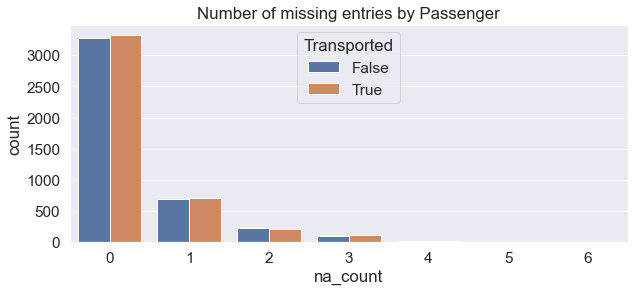

In [22]:
# Countplot of missing values by passengers
train['na_count'] = train.isna().sum(axis=1)  # counting missing values per passenger
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='na_count', hue='Transported')
plt.title('Number of missing entries by Passenger')
train.drop('na_count', axis=1, inplace=True)

Note:
- Even though the percentage of missing values are small, about 25% of all passengers have atleast 1 missing value
- PassengerId is the only feature to have zero missing values

Takeaway:
- If there is a relationship between the missing values and PassengerId and the other features we can fill missing values according to that feature.
- it makes more sense to fill in the missing values as compared to dropping them

Even though the easiest way to fill in the null values are with median and mode and it will be "good enough", but to maximise the accuracy of the model we need to look for patterns within the missing data. We can do this by looking at joint distribution of features, e.g. do passengers from the same group have the same family name? 

##### HomePlanet and Group

In [23]:
# Joint distribution of Group and HomePlanet
GHP_gb = data.groupby(['Group', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

HomePlanet,Earth,Europa,Mars
Group,,,
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,2.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0


Text(0.5, 1.0, 'Number of unique Home Planets per Group')

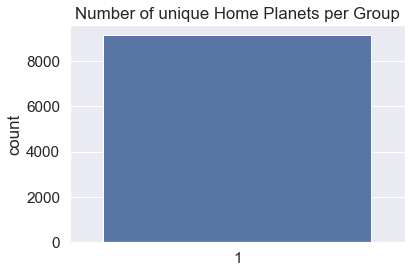

In [24]:
# Countplot of unique Values
sns.countplot((GHP_gb>0).sum(axis=1))
plt.title('Number of unique Home Planets per Group')

This shows that everyone in the same group comes from the same HomePlanet. This means we can fill the missing HomePlanet values according to the group.

In [25]:
# Missing values before
Home_bef = data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with a known planet
GHP_index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill in corresponding missing values 
data.loc[GHP_index, 'HomePlanet'] = data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Compare missing values before and after computing 
print('HomePlanet Missing Values before: ', Home_bef)
print('HomePlanet Missing Values after: ', data['HomePlanet'].isna().sum())

HomePlanet Missing Values before:  288
HomePlanet Missing Values after:  157


##### HomePlanet and Cabin Deck

<AxesSubplot:xlabel='C_deck', ylabel='HomePlanet'>

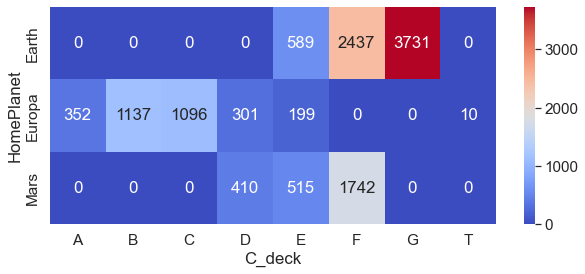

In [26]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb = data.groupby(['C_deck', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

Note:
- Passengers on A,B,C or T definitely came from Europa
- Passengers on G are definitely from earth
- Passengers on D,E,F are from multiple planets

In [27]:
# Missing values before
Home_bef = data['HomePlanet'].isna().sum()

# Assigning Europa to Passengers with Cabin Deck A,B,C or T
data.loc[(data['HomePlanet'].isna()) & (data['C_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'

# Assigning Earth to Passengers with Cabin Deck G
data.loc[(data['HomePlanet'].isna()) & (data['C_deck']=='G'), 'HomePlanet'] = 'Earth'

# Compare missing values before and after computing 
print('HomePlanet missing values before: ', Home_bef)
print('HomePlanet missing values after: ', data['HomePlanet'].isna().sum())

HomePlanet missing values before:  157
HomePlanet missing values after:  94


##### HomePlanet and Surname

Text(0.5, 1.0, 'Number of unique planets per surname')

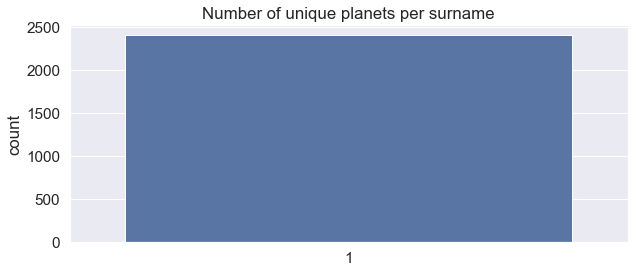

In [28]:
# Joint distribution of Surname and HomePlanet
SHP_gb = data.groupby(['Surname', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# CountPlot of unique values
plt.figure(figsize=(10,4))
sns.countplot((SHP_gb>0).sum(axis=1))
plt.title('Number of unique planets per surname')

This shows that everyone that has the same Surname comes from the same HomePlanet. This means we can fill the missing HomePlanet values according to their Surname.

In [29]:
# Missing values before
Home_bef = data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and is in a family with a known HomePlanet
SHP_index = data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index, 'HomePlanet'] = data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Compare missing values before and after computing 
print('HomePlanet missing values before: ', Home_bef)
print('HomePlanet missing values after: ', data['HomePlanet'].isna().sum())

HomePlanet missing values before:  94
HomePlanet missing values after:  10


In [30]:
# Looking at the last 10 missing values
data[data['HomePlanet'].isna()][['PassengerId', 'HomePlanet', 'Destination']]

,PassengerId,HomePlanet,Destination
2274,2443_01,NaN,TRAPPIST-1e
2631,2817_01,NaN,TRAPPIST-1e
3091,3331_01,NaN,TRAPPIST-1e
4548,4840_01,NaN,TRAPPIST-1e
5762,6108_01,NaN,TRAPPIST-1e
8969,0616_01,NaN,TRAPPIST-1e
10583,4052_01,NaN,TRAPPIST-1e
11913,7065_01,NaN,TRAPPIST-1e
12551,8435_01,NaN,TRAPPIST-1e
12725,8775_01,NaN,TRAPPIST-1e


All missing values are from passengers heading towards TRAPPIST-1e. 

##### HomePlanet and Destination

<AxesSubplot:xlabel='HomePlanet', ylabel='Destination'>

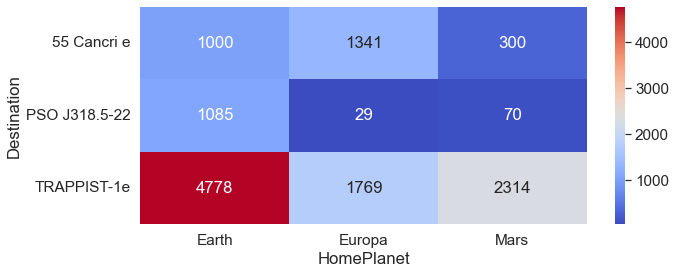

In [31]:
# Joint distribution of HomePlanet and Destination
HPD_gb = data.groupby(['HomePlanet', 'Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of Destination and HomePlanet
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

The two highest HomePlanet heading towards TRAPPIST-1e is Earth & Mars.
So I will be assigning missing values of the remaining HomePlanet to Earth while checking if they are on Deck D cause no one from Earth is in Deck D and then assigning them to Mars

In [32]:
# Missing values before
Home_bef = data['HomePlanet'].isna().sum()

# Fill missing values with Earth if not on Deck d or Mars if on Deck D
data.loc[(data['HomePlanet'].isna()) & ~(data['C_deck']=='D'), 'HomePlanet'] = 'Earth'
data.loc[(data['HomePlanet'].isna()) & (data['C_deck']=='D'), 'HomePlanet'] = 'Mars'

# Compare missing values before and after computing
print('HomePlanet missing values before: ', Home_bef)
print('HomePlanet missing values after: ', data['HomePlanet'].isna().sum())

HomePlanet missing values before:  10
HomePlanet missing values after:  0


##### Destination

I will be using mode to impute the missing values for Destination as majority of passengers (68%) are heading towards TRAPPIST-1e.

In [33]:
# Missing values before
Des_bef = data['Destination'].isna().sum()

# Fill missing values with TRAPPIST-1e (Mode)
data.loc[(data['Destination'].isna()), 'Destination'] = 'TRAPPIST-1e'

# Compare missing values before and after computing
print('Destination missing values before: ', Des_bef)
print('Destination missing values after: ', data['Destination'].isna().sum())

Destination missing values before:  274
Destination missing values after:  0


##### Surname and Group

I will be filling in the missing values for surname as I will be using them to fill missing values of other features. I can also improve accuracy for family size feature.

Text(0.5, 1.0, 'Number of unique surnames by group')

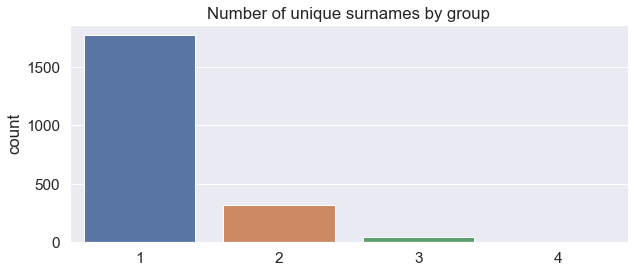

In [34]:
# Joint distribution of Group and Surname
GSN_gb = data[data['Group_size']>1].groupby(['Group', 'Surname'])['Surname'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((GSN_gb>0).sum(axis=1))
plt.title('Number of unique surnames by group')

In [35]:
#missing values before
SN_bef = data['Surname'].isna().sum()

# Passengers with missing Surnames and in a group with known majority Surname
GSN_index = data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index, 'Surname'] = data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Compare missing values before and after computing
print('Surname missing values before: ', SN_bef)
print('Surname missing values after: ', data['Surname'].isna().sum())

Surname missing values before:  294
Surname missing values after:  155


The majority of groups (83%) contain only one family. So I will be filling surnames according to the majority surname in that group

In [36]:
# Replace missing values with an Outlier
data['Surname'].fillna('Unknown', inplace=True)

# Update Family size
data['Fam_size'] = data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

# Assingning back NaN 
data.loc[data['Surname']=='Unknown', 'Surname'] = np.nan

# Assigning no family to unknown Surname
data.loc[data['Fam_size']>100, 'Fam_size'] = 0

#### CabinSide and Group

Text(0.5, 1.0, 'Unique Side per group')

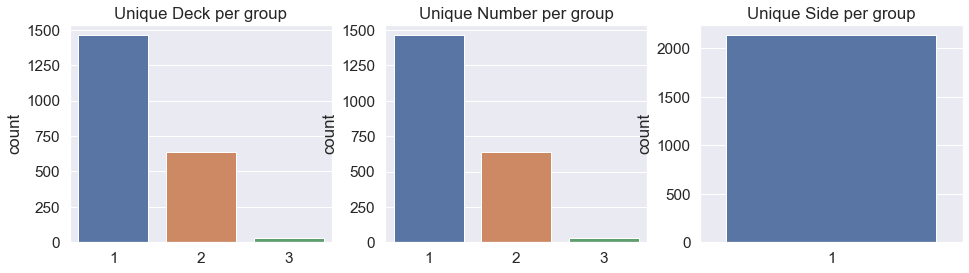

In [37]:
# Joint distribution of Group and Cabin features
GCD_gb = data[data['Group_size']>1].groupby(['Group', 'C_deck'])['C_deck'].size().unstack().fillna(0)
GCN_gb = data[data['Group_size']>1].groupby(['Group', 'C_number'])['C_number'].size().unstack().fillna(0)
GCS_gb = data[data['Group_size']>1].groupby(['Group', 'C_side'])['C_side'].size().unstack().fillna(0)

# Countplots of Joint distri
fig = plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((GCD_gb>0).sum(axis=1))
plt.title('Unique Deck per group')

plt.subplot(1,3,2)
sns.countplot((GCN_gb>0).sum(axis=1))
plt.title('Unique Number per group')

plt.subplot(1,3,3)
sns.countplot((GCS_gb>0).sum(axis=1))
plt.title('Unique Side per group')

Everyone in the same group stayed at the same Cabin Side. For Deck and Number its high but not perfect to assign values.

In [38]:
# Missing values before
CSide_bef = data['C_side'].isna().sum()

# Passengers with missing Cabin Side in a Group with known Cabin Side
GCS_index = data[data['C_side'].isna()][(data[data['C_side'].isna()]['Group']).isin(GCS_gb.index)].index

# Fill corresponding missing values
data.loc[GCS_index, 'C_side'] = data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Compare missing values before and after cumputing
print('Cabin Side missing values before: ', CSide_bef)
print('Cabin Side missing values after: ', data['C_side'].isna().sum())

Cabin Side missing values before:  299
Cabin Side missing values after:  162


#### CabinSide and Surname

Text(0.5, 1.0, 'Ratio of Cabin Side with Same Surname')

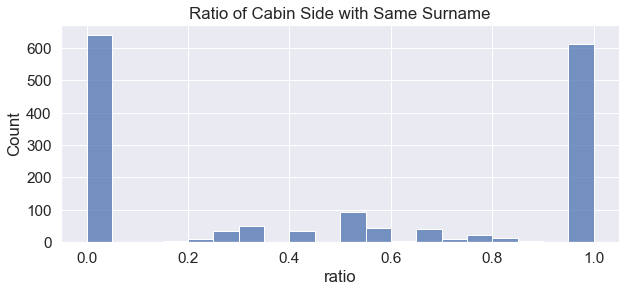

In [39]:
# Joint distribution of Surname and Cabin Side
SCS_gb = data[data['Group_size']>1].groupby(['Surname', 'C_side'])['C_side'].size().unstack().fillna(0)

# Ratio of sides
SCS_gb['ratio'] = SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

# Histogram of ratio
plt.figure(figsize=(10,4))
sns.histplot(SCS_gb['ratio'], binwidth = 0.05)
plt.title('Ratio of Cabin Side with Same Surname')

In [40]:
# Print percentage of families on the same side
print('Percentage of families all on the same side of the Cabin: ', 100*np.round((SCS_gb['ratio'].isin([0,1])).sum()/len(SCS_gb), 3), '%')

# Same info but in table form
SCS_gb.head()

Percentage of families all on the same side of the Cabin:  76.7 %


C_side,P,S,ratio
Surname,,,
Acobson,0.0,3.0,0.0
Acobsond,3.0,0.0,1.0
Adavisons,6.0,0.0,1.0
Admingried,0.0,4.0,0.0
Aginge,3.0,0.0,1.0


In [41]:
# Missing values before
CSide_bef = data['C_side'].isna().sum()

# Drop ratio column
SCS_gb.drop('ratio', axis=1, inplace=True)

# Passengers with missing Cabin Side in the same family with known Cabin Side
SCS_index = data[data['C_side'].isna()][(data[data['C_side'].isna()]['Surname']).isin(SCS_gb.index)].index

# Fill corresponding values
data.loc[SCS_index, 'C_side'] = data.iloc[SCS_index, :]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# Drop Surname column (don't need it anymore)
data.drop('Surname', axis=1, inplace=True)

# Compare missing values before and after computing
print('Cabin side missing values before: ', CSide_bef)
print('Cabin side missing values after: ', data['C_side'].isna().sum())

Cabin side missing values before:  162
Cabin side missing values after:  66


In [42]:
# Value counts of sides S and P
data['C_side'].value_counts()

S    6504
P    6400
Name: C_side, dtype: int64

Since the two sides are very balanced I will be just replacing the remaining values with an outlier

In [43]:
# Missing values before
CSide_bef = data['C_side'].isna().sum()

# Replacing missing values with outlier
data.loc[data['C_side'].isna(), 'C_side'] = 'Z'

# Compare missng values before and after computing
print('Cabin side missing values before: ', CSide_bef)
print('Cabin side missing values after: ', data['C_side'].isna().sum())

Cabin side missing values before:  66
Cabin side missing values after:  0


#### CabinDeck and Group

I pointed out previously groups tend to be on the same cabin deck.

In [44]:
# Missing values before
CDeck_bef = data['C_deck'].isna().sum()

# Passengers with missing Cabin Deck in Group with known Majority Cabin Deck
GCD_index = data[data['C_deck'].isna()][(data[data['C_deck'].isna()]['Group']).isin(GCD_gb.index)].index

# Fill corresponding values
data.loc[GCD_index, 'C_deck'] = data.iloc[GCD_index, :]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Compare missing values before and after computing
print('Cabin Deck missing values before: ', CDeck_bef)
print('Cabin Deck missing after: ', data['C_deck'].isna().sum())

Cabin Deck missing values before:  299
Cabin Deck missing after:  162


#### CabinDeck and HomePlanet

In [45]:
# Joint distribution
data.groupby(['HomePlanet','Destination','Solo','C_deck'])['C_deck'].size().unstack().fillna(0)

C_deck                             A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

C_deck                              G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

Note:
- Passengers from Mars are most likely in Deck F
- Passengers from Europa are likely in Deck C if travelling solo and deck B otherwise.
- Passengers from Earth are likely in Deck G

We will fill in missing values according to where the mode appears in these subgroups

In [46]:
# Missing values before
CDeck_bef = data['C_deck'].isna().sum()

# Fill missing values with mode
na_rows_CDeck = data.loc[data['C_deck'].isna(), 'C_deck'].index
data.loc[data['C_deck'].isna(), 'C_deck'] = data.groupby(['HomePlanet', 'Destination', 'Solo'])['C_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CDeck]

# Compare missing values before and after computing
print('Cabin Deck missing values before: ', CDeck_bef)
print('Cabin Deck missing values after: ', data['C_deck'].isna().sum())

Cabin Deck missing values before:  162
Cabin Deck missing values after:  0


#### CabinNumber and CabinDeck

Text(0.5, 1.0, 'Cabin Number vs Group (colored by Group)')

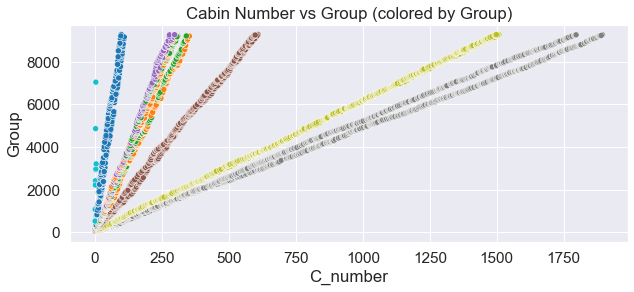

In [47]:
# Scatterplot
plt.figure(figsize=(10,4))
sns.scatterplot(x=data['C_number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['C_number'].isna(), 'C_deck']), cmap='tab10')
plt.title('Cabin Number vs Group (colored by Group)')

The cabin number and group number share a linear relationship on a deck by deck basis. Using linear regression on a deck by deck basis, we can predict the approximate cabin number

In [48]:
# Missing values before
CNumber_bef = data['C_number'].isna().sum()

# Using Linear Relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    X_CNumber = data.loc[~(data['C_number'].isna()) & (data['C_deck']==deck), 'Group']
    y_CNumber = data.loc[~(data['C_number'].isna()) & (data['C_deck']==deck), 'C_number']
    X_test_CNumber = data.loc[(data['C_number'].isna()) & (data['C_deck']==deck), 'Group']
    
    # Linear regression
    model_CNumber = LinearRegression()
    model_CNumber.fit(X_CNumber.values.reshape(-1, 1), y_CNumber)
    pred_CNumber = model_CNumber.predict(X_test_CNumber.values.reshape(-1,1))
    
    # Fill in missing values
    data.loc[(data['C_number'].isna()) & (data['C_deck']==deck), 'C_number'] = pred_CNumber.astype(int)
    
print('Cabin Numbers missing values before: ', CNumber_bef)
print('Cabin Numbers missing values after: ', data['C_number'].isna().sum())

Cabin Numbers missing values before:  299
Cabin Numbers missing values after:  0


Updating the cabin regions with new data.

In [49]:
# Updating cabin region features
data['C_region1']=(data['C_number']<300).astype(int)
data['C_region2']=((data['C_number']>=300) & (data['C_number']<600)).astype(int)
data['C_region3']=((data['C_number']>=600) & (data['C_number']<900)).astype(int)
data['C_region4']=((data['C_number']>=900) & (data['C_number']<1200)).astype(int)
data['C_region5']=((data['C_number']>=1200) & (data['C_number']<1500)).astype(int)
data['C_region6']=((data['C_number']>=1500) & (data['C_number']<1800)).astype(int)
data['C_region7']=(data['C_number']>=1800).astype(int)

#### VIP

VIP is very unbalanced binary feature hence we will just use mode to fill in the missing values

In [50]:
data['VIP'].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

In [51]:
# Missing values before
V_bef = data['VIP'].isna().sum()

# Fill missing values with mode
data.loc[data['VIP'].isna(), 'VIP'] = 'False'

print('VIP missing values before: ', V_bef)
print('VIP missing values after: ', data['VIP'].isna().sum())

VIP missing values before:  296
VIP missing values after:  0


#### Age

Since age varies across alot of the features, I will be imputing the missing values according to the median of the subgroups of the features

In [52]:
# Joint distribution
data.groupby(['HomePlanet','No_Spending','Solo','C_deck'])['Age'].median().unstack().fillna(0)

C_deck                          A     B     C     D     E     F     G     T
HomePlanet No_Spending Solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                       1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1           0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                       1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1           0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [53]:
# Missing values before
Age_bef = data['Age'].isna().sum()

# Fill in missing values with median
na_rows_Age = data.loc[data['Age'].isna(), 'Age'].index
data.loc[data['Age'].isna(), 'Age'] = data.groupby(['HomePlanet', 'No_Spending', 'Solo', 'C_deck'])['Age'].transform(lambda x: x.fillna(x.median()))[na_rows_Age]

print('Age missing values before: ', Age_bef)
print('Age missing values after: ', data['Age'].isna().sum())

Age missing values before:  270
Age missing values after:  0


Updating the age_group feature using the new data.

In [54]:
# Update age group feature
data.loc[data['Age']<=12,'Age_group']='Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
data.loc[data['Age']>50,'Age_group']='Age_51+'

#### CryoSleep

If passengers are in CryoSleep the didnt spent on anything.

In [55]:
data.groupby(['No_Spending', 'CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep,False,True
No_Spending,,
0,7339.0,0.0
1,740.0,4581.0


In [56]:
# Missing values before
CSL_bef = data['CryoSleep'].isna().sum()

# Fill in missing values with mode
na_rows_CSL = data.loc[data['CryoSleep'].isna(), 'CryoSleep'].index
data.loc[data['CryoSleep'].isna(), 'CryoSleep'] = data.groupby(['No_Spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

print('CryoSleep missing data before: ', CSL_bef)
print('CryoSleep missig data after: ', data['CryoSleep'].isna().sum())

CryoSleep missing data before:  310
CryoSleep missig data after:  0


#### Expenditure and CryoSleep

This one makes a lot of sense as we dont expect passengers in CryoSleep to be able to spend anything 

In [57]:
# Missing values before
Ex_bef = data[exp_feats].isna().sum().sum()

# CryoSleep has no expenditure
for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col] = 0
    
print('Expenditure missing before: ', Ex_bef)
print('Expenditure missing after: ', data[exp_feats].isna().sum().sum())

Expenditure missing before:  1410
Expenditure missing after:  866


#### Expenditure and others

Expenditure varies across many features but we will only impute missing values using HomePlanet, Solo and Age group to prevent overfitting. We will also use the mean instead of the median because a large proportion of passengers don't spend anything and median usually comes out as 0. Note how under 12's don't spend anything.

In [58]:
data.groupby(['HomePlanet', 'Solo', 'Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   724.902222   789.700555   841.093596   736.655773   
           1          0.0   693.014898   779.395942   795.420690   794.818627   
Europa     0          0.0  1153.160256  2652.013298  3534.668246  3975.774005   
           1          0.0     0.000000  2489.888889  3806.000000  3949.939929   
Mars       0          0.0  1176.839286  1161.808333  1247.098361  1143.671916   
           1          0.0  1687.261538  1075.341146  1107.122677  1110.392045   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

In [59]:
Ex_bef = data[exp_feats].isna().sum().sum()

for col in exp_feats:
    na_rows = data.loc[data[col].isna(), col].index
    data.loc[data[col].isna(), col] = data.groupby(['HomePlanet', 'Solo', 'Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]
    
print('Expenditure missing before: ', Ex_bef)
print('Expenditure missing after: ', data[exp_feats].isna().sum().sum())

Expenditure missing before:  866
Expenditure missing after:  0


In [60]:
data['Expenditure']=data[exp_feats].sum(axis=1)
data['No_Spending']=(data['Expenditure']==0).astype(int)

In [61]:
data.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Age_group       0
Expenditure     0
No_Spending     0
Group           0
Group_size      0
Solo            0
C_deck          0
C_number        0
C_side          0
C_region1       0
C_region2       0
C_region3       0
C_region4       0
C_region5       0
C_region6       0
C_region7       0
Fam_size        0
dtype: int64

In [62]:
X=data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
X_test=data[data['PassengerId'].isin(test['PassengerId'].values)].copy()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4277 entries, 8693 to 12969
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4277 non-null   object 
 2   CryoSleep     4277 non-null   object 
 3   Destination   4277 non-null   object 
 4   Age           4277 non-null   float64
 5   VIP           4277 non-null   object 
 6   RoomService   4277 non-null   float64
 7   FoodCourt     4277 non-null   float64
 8   ShoppingMall  4277 non-null   float64
 9   Spa           4277 non-null   float64
 10  VRDeck        4277 non-null   float64
 11  Age_group     4277 non-null   object 
 12  Expenditure   4277 non-null   float64
 13  No_Spending   4277 non-null   int32  
 14  Group         4277 non-null   int32  
 15  Group_size    4277 non-null   int64  
 16  Solo          4277 non-null   int32  
 17  C_deck        4277 non-null   object 
 18  C_number      4277 non-n

In [63]:
cabin_region = X[["PassengerId","C_region1","C_region2","C_region3","C_region4","C_region5","C_region6","C_region7"]]
cabin_region_test = X_test[["PassengerId","C_region1","C_region2","C_region3","C_region4","C_region5","C_region6","C_region7"]]

cabin_region['C_region_all'] = (cabin_region.iloc[:,1:] == 1).idxmax(1)
cabin_region_test['C_region_all'] = (cabin_region_test.iloc[:,1:] == 1).idxmax(1)

cabin_region.drop(cabin_region.columns.difference(['PassengerId','C_region_all']), 1, inplace=True)
cabin_region_test.drop(cabin_region_test.columns.difference(['PassengerId','C_region_all']), 1, inplace=True)

X = pd.merge(X, cabin_region)
X_test = pd.merge(X_test, cabin_region_test)

X.drop(['C_region1', 'C_region2', 'C_region3', 'C_region4', 'C_region5', 'C_region6', 'C_region7'], axis = 1, inplace = True)
X_test.drop(['C_region1', 'C_region2', 'C_region3', 'C_region4', 'C_region5', 'C_region6', 'C_region7'], axis = 1, inplace = True)

X.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Expenditure,No_Spending,Group,Group_size,Solo,C_deck,C_number,C_side,Fam_size,C_region_all
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,1,1,1,1,B,0.0,P,4,C_region1
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,736.0,0,2,1,1,F,0.0,S,4,C_region1
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,...,10383.0,0,3,2,0,A,0.0,S,7,C_region1
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,...,5176.0,0,3,2,0,A,0.0,S,7,C_region1
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,1091.0,0,4,1,1,F,1.0,S,9,C_region1


In [64]:
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'C_number', 'VIP'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'C_number', 'VIP'], axis=1, inplace=True)

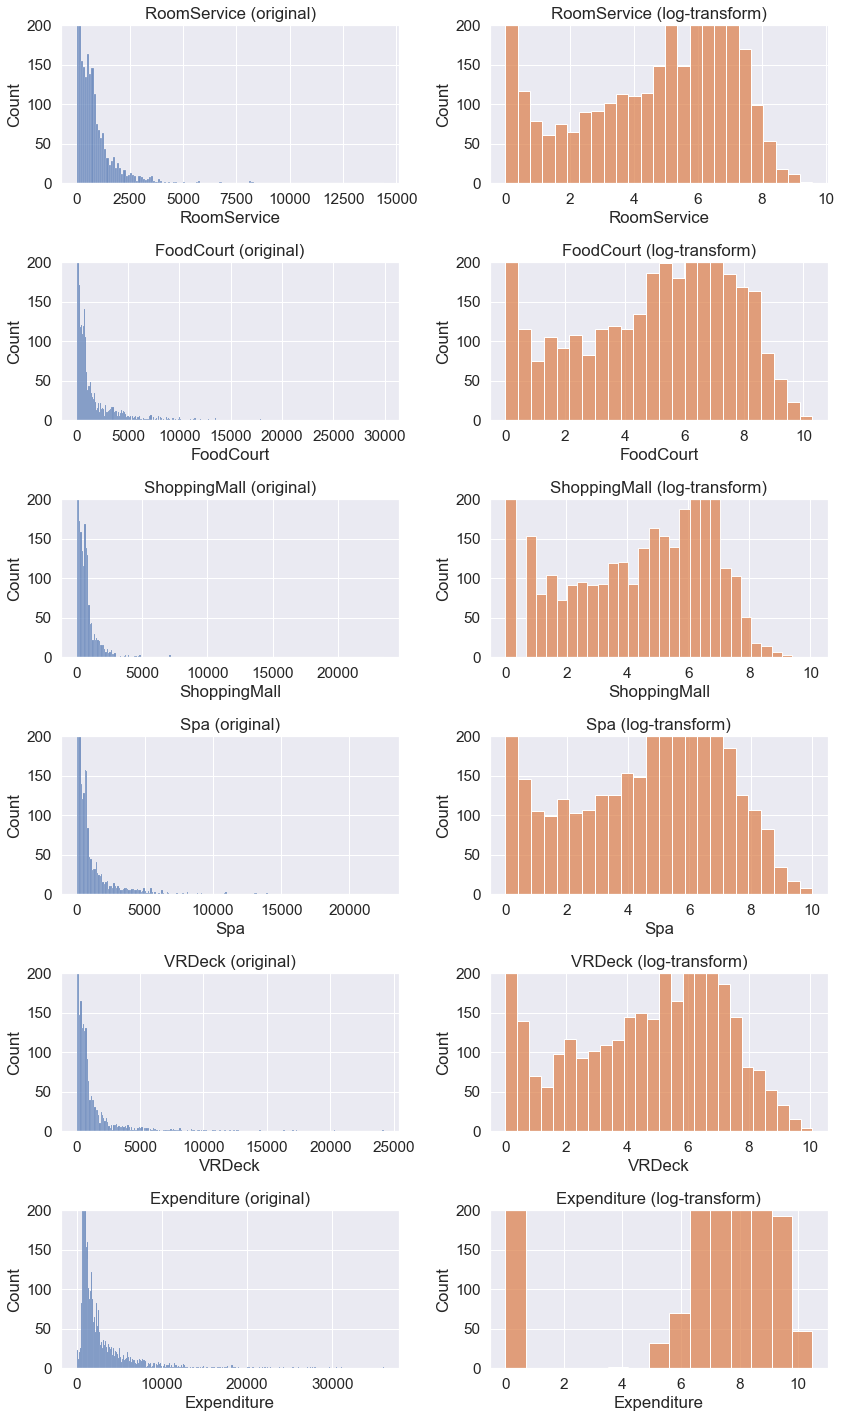

In [65]:
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

In [66]:
 for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

In [67]:
# Creating an instance of Label Encoder
le = LabelEncoder()
cols = ['CryoSleep', 'HomePlanet', 'Destination', 'C_side', 'C_deck', 'C_region_all']

# Using .fit_transform function to fit label
X[cols] = X[cols].apply(LabelEncoder().fit_transform)
X_test[cols] = X_test[cols].apply(LabelEncoder().fit_transform)

X.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure,No_Spending,Solo,C_deck,C_side,Fam_size,C_region_all
0,1,0,2,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,0,4,0
1,0,0,2,24.0,4.700480,2.302585,3.258097,6.309918,3.806662,6.602588,0,1,5,1,4,0
2,1,0,2,58.0,3.784190,8.182280,0.000000,8.812248,3.912023,9.248021,0,0,0,1,7,0
3,1,0,2,33.0,0.000000,7.157735,5.918894,8.110728,5.267858,8.551981,0,0,0,1,7,0
4,0,0,2,16.0,5.717028,4.262680,5.023881,6.338594,1.098612,6.995766,0,1,5,1,9,0


In [68]:
X = X[['Age', 'Solo', 'Fam_size', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure', 'No_Spending', 'CryoSleep', 'C_deck', 'C_region_all', 'C_side', 'HomePlanet', 'Destination']] 
X_test = X_test[['Age', 'Solo', 'Fam_size', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure', 'No_Spending', 'CryoSleep', 'C_deck', 'C_region_all', 'C_side', 'HomePlanet', 'Destination']] 

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           8693 non-null   float64
 1   Solo          8693 non-null   int32  
 2   Fam_size      8693 non-null   int64  
 3   RoomService   8693 non-null   float64
 4   FoodCourt     8693 non-null   float64
 5   ShoppingMall  8693 non-null   float64
 6   Spa           8693 non-null   float64
 7   VRDeck        8693 non-null   float64
 8   Expenditure   8693 non-null   float64
 9   No_Spending   8693 non-null   int32  
 10  CryoSleep     8693 non-null   int32  
 11  C_deck        8693 non-null   int32  
 12  C_region_all  8693 non-null   int32  
 13  C_side        8693 non-null   int32  
 14  HomePlanet    8693 non-null   int32  
 15  Destination   8693 non-null   int32  
dtypes: float64(7), int32(8), int64(1)
memory usage: 882.9 KB


In [70]:
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [71]:
X_train

,Age,Solo,Fam_size,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Expenditure,No_Spending,CryoSleep,C_deck,C_region_all,C_side,HomePlanet,Destination
6617,41.0,1,6,0.000000,0.000000,0.000000,0.000000,6.444131,6.444131,0,0,5,4,1,0,1
524,44.0,0,12,7.273093,5.683580,4.317488,3.496508,0.000000,7.517521,0,0,5,0,1,0,2
3867,54.0,0,4,0.000000,7.141861,0.000000,8.071219,0.000000,8.403751,0,0,2,0,1,1,2
4231,26.0,1,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,4,0,0,2,2
7287,45.0,0,10,6.698268,0.000000,4.890349,5.293305,0.000000,7.039660,0,0,5,4,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,32.0,0,6,0.000000,0.000000,6.928538,0.000000,0.000000,6.928538,0,0,5,2,0,0,2
1795,46.0,1,14,2.197225,6.481577,0.000000,1.791759,4.510860,6.628041,0,0,6,1,1,0,2
4984,31.0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,4,1,0,1,0
1127,52.0,1,9,0.000000,5.497168,6.142037,4.276666,2.197225,6.668228,0,0,4,0,0,0,2


# Prediction Model

## Logistic Regression

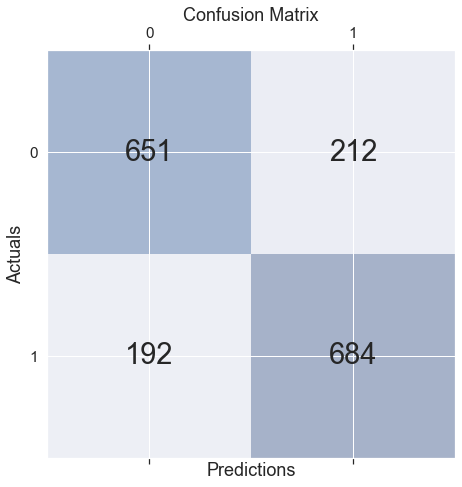

In [72]:
lm = LogisticRegression()
lm.fit(X_train, y_train)
lm_pred = lm.predict(X_valid)

conf_matrix = metrics.confusion_matrix(y_valid, lm_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [73]:
print(classification_report(y_valid, lm_pred))

              precision    recall  f1-score   support

       False       0.77      0.75      0.76       863
        True       0.76      0.78      0.77       876

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



In [74]:
accuracies = cross_val_score(estimator = lm, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 77.62 %
Standard Deviation: 1.69 %


## Random Forest 

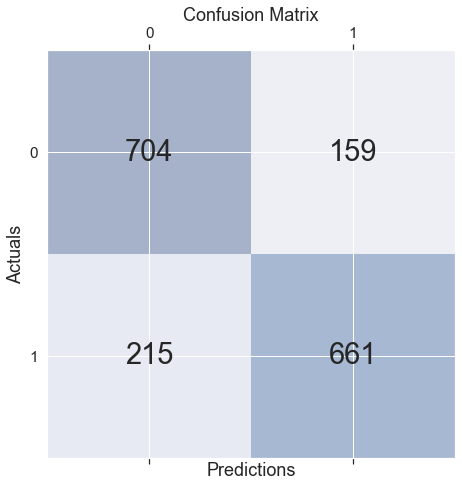

In [75]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
conf_matrix = metrics.confusion_matrix(y_valid, rf_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [76]:
print(classification_report(y_valid, rf_pred))

              precision    recall  f1-score   support

       False       0.77      0.82      0.79       863
        True       0.81      0.75      0.78       876

    accuracy                           0.78      1739
   macro avg       0.79      0.79      0.78      1739
weighted avg       0.79      0.78      0.78      1739



In [77]:
accuracies = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 80.30 %
Standard Deviation: 1.61 %


## KNeighborsClassifer

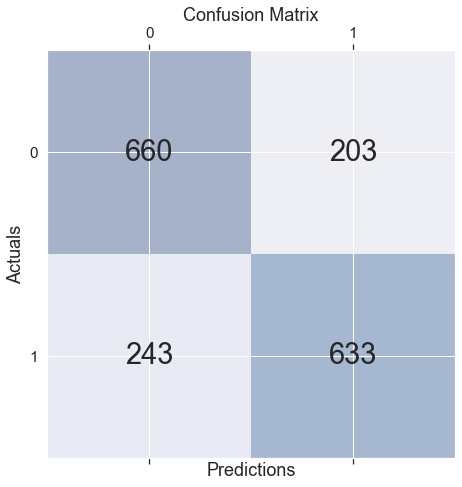

In [78]:
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
KNN_pred = KNN.predict(X_valid)
conf_matrix = metrics.confusion_matrix(y_valid, KNN_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [79]:
print(classification_report(y_valid, KNN_pred))

              precision    recall  f1-score   support

       False       0.73      0.76      0.75       863
        True       0.76      0.72      0.74       876

    accuracy                           0.74      1739
   macro avg       0.74      0.74      0.74      1739
weighted avg       0.74      0.74      0.74      1739



In [80]:
accuracies = cross_val_score(estimator = KNN, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 75.57 %
Standard Deviation: 1.62 %


## SVC

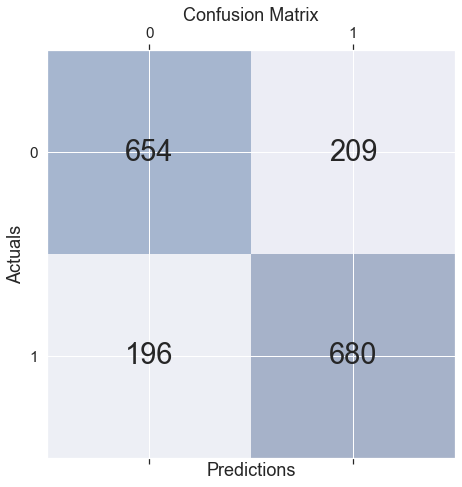

In [81]:
SVC1 = SVC(random_state=0, probability=True)
SVC1.fit(X_train, y_train)
SVC1_pred = SVC1.predict(X_valid)
conf_matrix = metrics.confusion_matrix(y_valid, SVC1_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [82]:
print(classification_report(y_valid, SVC1_pred))

              precision    recall  f1-score   support

       False       0.77      0.76      0.76       863
        True       0.76      0.78      0.77       876

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



In [83]:
accuracies = cross_val_score(estimator = SVC1, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 77.96 %
Standard Deviation: 1.69 %


## Decision Tree

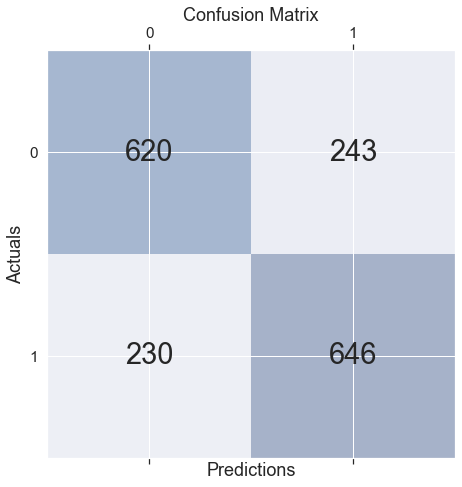

In [84]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_valid)
conf_matrix = metrics.confusion_matrix(y_valid, dt_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [85]:
print(classification_report(y_valid, dt_pred))

              precision    recall  f1-score   support

       False       0.73      0.72      0.72       863
        True       0.73      0.74      0.73       876

    accuracy                           0.73      1739
   macro avg       0.73      0.73      0.73      1739
weighted avg       0.73      0.73      0.73      1739



In [86]:
accuracies = cross_val_score(estimator = dt, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 74.81 %
Standard Deviation: 1.80 %


## NaiveBayes

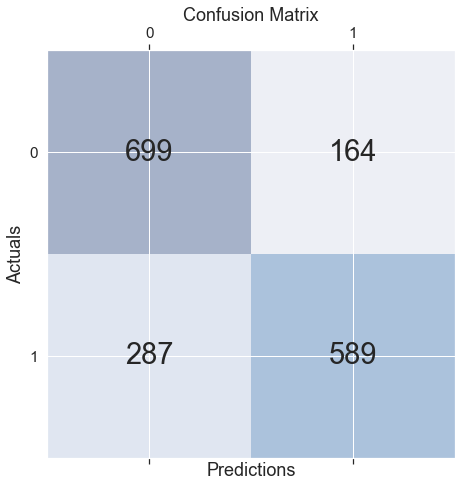

In [87]:
NB = GaussianNB()
NB.fit(X_train, y_train)
NB_pred = NB.predict(X_valid)
conf_matrix = metrics.confusion_matrix(y_valid, NB_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [88]:
print(classification_report(y_valid, NB_pred))

              precision    recall  f1-score   support

       False       0.71      0.81      0.76       863
        True       0.78      0.67      0.72       876

    accuracy                           0.74      1739
   macro avg       0.75      0.74      0.74      1739
weighted avg       0.75      0.74      0.74      1739



In [89]:
accuracies = cross_val_score(estimator = NB, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 73.83 %
Standard Deviation: 1.39 %


## LGBM

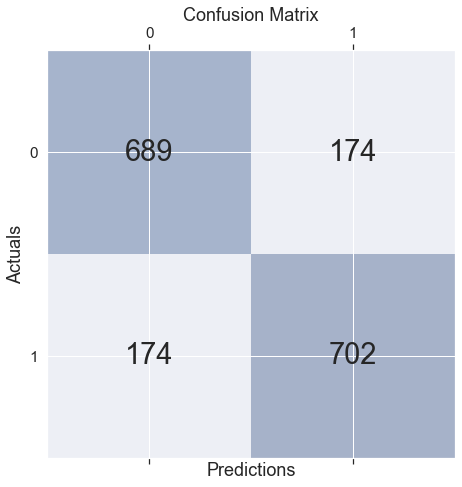

In [90]:
LGBM = LGBMClassifier(random_state=0)
LGBM.fit(X_train, y_train)
LGBM_pred = LGBM.predict(X_valid)
conf_matrix = metrics.confusion_matrix(y_valid, LGBM_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [91]:
print(classification_report(y_valid, LGBM_pred))

              precision    recall  f1-score   support

       False       0.80      0.80      0.80       863
        True       0.80      0.80      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



In [92]:
accuracies = cross_val_score(estimator = LGBM, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 81.09 %
Standard Deviation: 1.22 %


# Hyperparameter Tuning

## GridSearchCV

In [93]:
param_grid_LGBM = {'n_estimators': [5, 10, 50, 100, 150, 200],
        'max_depth': [4, 8, 12, 16],
        'num_leaves': [6,8,12,16],
        'learning_rate': [0.005, 0.05, 0.1, 0.15]}
grid_LGBM = GridSearchCV(LGBMClassifier(), param_grid_LGBM, refit = True, verbose = 4)

In [94]:
grid_LGBM.fit(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV 1/5] END learning_rate=0.005, max_depth=4, n_estimators=5, num_leaves=6;, score=0.728 total time=   0.0s
[CV 2/5] END learning_rate=0.005, max_depth=4, n_estimators=5, num_leaves=6;, score=0.761 total time=   0.0s
[CV 3/5] END learning_rate=0.005, max_depth=4, n_estimators=5, num_leaves=6;, score=0.760 total time=   0.0s
[CV 4/5] END learning_rate=0.005, max_depth=4, n_estimators=5, num_leaves=6;, score=0.747 total time=   0.0s
[CV 5/5] END learning_rate=0.005, max_depth=4, n_estimators=5, num_leaves=6;, score=0.769 total time=   0.0s
[CV 1/5] END learning_rate=0.005, max_depth=4, n_estimators=5, num_leaves=8;, score=0.733 total time=   0.0s
[CV 2/5] END learning_rate=0.005, max_depth=4, n_estimators=5, num_leaves=8;, score=0.791 total time=   0.0s
[CV 3/5] END learning_rate=0.005, max_depth=4, n_estimators=5, num_leaves=8;, score=0.772 total time=   0.0s
[CV 4/5] END learning_rate=0.005, max_depth=4, n_estimators=5, n

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.005, 0.05, 0.1, 0.15],
                         'max_depth': [4, 8, 12, 16],
                         'n_estimators': [5, 10, 50, 100, 150, 200],
                         'num_leaves': [6, 8, 12, 16]},
             verbose=4)

In [95]:
grid_LGBM.best_params_

{'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 200, 'num_leaves': 16}

<AxesSubplot:>

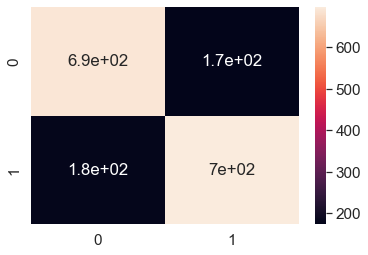

In [96]:
grid_predictions_LGBM = grid_LGBM.predict(X_valid)
cm = confusion_matrix(y_valid, grid_predictions_LGBM)
sns.heatmap(cm, annot = True)

In [97]:
print(classification_report(y_valid, grid_predictions_LGBM))

              precision    recall  f1-score   support

       False       0.79      0.80      0.80       863
        True       0.80      0.80      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



In [98]:
param_grid_rf = {'n_estimators': [50, 100, 150, 200, 250, 300], 
           'max_depth': [4, 6, 8, 10, 12]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, refit = True, verbose = 4)

In [99]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ......max_depth=4, n_estimators=50;, score=0.762 total time=   0.0s
[CV 2/5] END ......max_depth=4, n_estimators=50;, score=0.776 total time=   0.0s
[CV 3/5] END ......max_depth=4, n_estimators=50;, score=0.756 total time=   0.0s
[CV 4/5] END ......max_depth=4, n_estimators=50;, score=0.761 total time=   0.0s
[CV 5/5] END ......max_depth=4, n_estimators=50;, score=0.770 total time=   0.0s
[CV 1/5] END .....max_depth=4, n_estimators=100;, score=0.756 total time=   0.2s
[CV 2/5] END .....max_depth=4, n_estimators=100;, score=0.774 total time=   0.2s
[CV 3/5] END .....max_depth=4, n_estimators=100;, score=0.763 total time=   0.2s
[CV 4/5] END .....max_depth=4, n_estimators=100;, score=0.754 total time=   0.2s
[CV 5/5] END .....max_depth=4, n_estimators=100;, score=0.765 total time=   0.1s
[CV 1/5] END .....max_depth=4, n_estimators=150;, score=0.762 total time=   0.3s
[CV 2/5] END .....max_depth=4, n_estimators=150

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 6, 8, 10, 12],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             verbose=4)

In [100]:
grid_rf.best_params_

{'max_depth': 12, 'n_estimators': 250}

<AxesSubplot:>

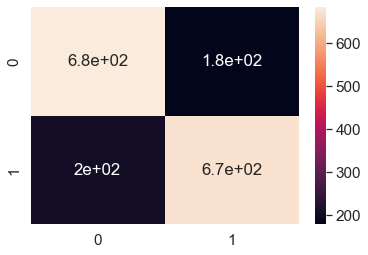

In [101]:
grid_predictions_rf = grid_rf.predict(X_valid)
cm = confusion_matrix(y_valid, grid_predictions_rf)
sns.heatmap(cm, annot = True)

In [102]:
print(classification_report(y_valid, grid_predictions_rf))

              precision    recall  f1-score   support

       False       0.77      0.79      0.78       863
        True       0.79      0.77      0.78       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



## RandomSearchCV

In [103]:
fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X,y)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc = 0.2, scale = 0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc = 0.4, scale = 0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

# Number of combinations
n_iter = 500 

# Intializing lgbm and lunching the search
lgbm_clf = LGBMClassifier(random_state = 42, silent = True, metric = 'None', n_jobs = 4)
grid_search = RandomizedSearchCV(
    estimator = lgbm_clf, param_distributions = param_test, 
    n_iter = n_iter,
    scoring = 'accuracy',
    cv = 5,
    refit = True,
    random_state = 42,
    verbose = True)

grid_search.fit(X, y, **fit_params)
opt_parameters = grid_search.best_params_

# Predicting y_test
lgbm_clf = LGBMClassifier(**opt_parameters)
y_pred = lgbm_clf.fit(X, y).predict(X_valid)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


<AxesSubplot:>

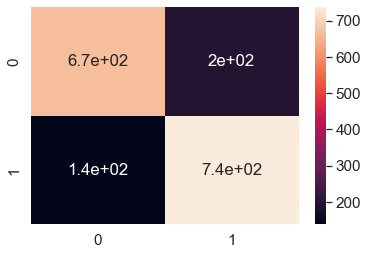

In [104]:
predictions_lgbm = lgbm_clf.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)

In [105]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.77      0.80       863
        True       0.79      0.84      0.82       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



In [106]:
joblib.dump(lgbm_clf, "model.pkl")

['model.pkl']